# Lesson 2, State of the Art and Testing Models

* Key items for this week:

  * ImageDatabunch
  * cnn_learner
* Models we will look at:
  * xResNet [Bag of Tricks](https://arxiv.org/abs/1812.01187)
  * Densenet [Densenet Paper](https://arxiv.org/abs/1608.06993?source=post_page---------------------------)
  * EfficiencyNet [EfficiencyNet Paper](https://arxiv.org/abs/1905.11946)


In [0]:
from fastai.vision import *
from fastai.vision.models.xresnet import *

# Dataset:

Our dataset today will be ImageWoof. [Link](https://github.com/fastai/imagenette)

Goal: Using no pre-trained weights, see how well of accuracy we can get in x epochs



In [0]:
def get_data(size, woof, bs, workers=None):
    if   size<=128: path = URLs.IMAGEWOOF_160 if woof else URLs.IMAGENETTE_160
    elif size<=224: path = URLs.IMAGEWOOF_320 if woof else URLs.IMAGENETTE_320
    else          : path = URLs.IMAGEWOOF     if woof else URLs.IMAGENETTE
    path = untar_data(path)

    n_gpus = num_distrib() or 1
    if workers is None: workers = min(8, num_cpus()//n_gpus)

    return (ImageList.from_folder(path).split_by_folder(valid='val')
            .label_from_folder().transform(([flip_lr(p=0.5)], []), size=size)
            .databunch(bs=bs, num_workers=workers)
            .presize(size, scale=(0.35,1))
            .normalize(imagenet_stats))

In [0]:
data = get_data(256, True, 64)

# Key Ideas:

* Label Smoothing Cross Entropy - State of the art in classification loss functions (We will explore this more in week 6) [paper](https://arxiv.org/abs/1906.11567)

  * Basically threshold instead of 1/0

* MixUp [docs](https://docs.fast.ai/callbacks.mixup.html)
  * Mixup involves "mixing" sets of images together instead of feeding raw images
  


# Label Smoothing Cross Entropy

I won't go into specifics of how it all works, as that will be for week . However here is the code:

In [0]:
from torch.distributions.beta import Beta

def lin_comb(a, b, frac_a): return (frac_a * a) + (1 - frac_a) * b

def unsqueeze(input, dims):
    for dim in listify(dims): input = torch.unsqueeze(input, dim)
    return input

def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction=='mean' else loss.sum() if reduction=='sum' else loss

class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, ε:float=0.1, reduction='mean'):
        super().__init__()
        self.ε,self.reduction = ε,reduction

    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        loss = reduce_loss(-log_preds.sum(dim=-1), self.reduction)
        nll = F.nll_loss(log_preds, target, reduction=self.reduction)
        return lin_comb(loss/c, nll, self.ε)

# Mixup:

  A very basic example:
  
  `new_image = t * image1 + (1-t) * image2`
  
  Where `t` is a float between 0 and 1. The target we assign is the same combination as the original,
  `new_target = t * target1 + (1-t) * target2`

In [14]:
img1, lbl1 = data.train_ds[0]; lbl1

Category n02096294

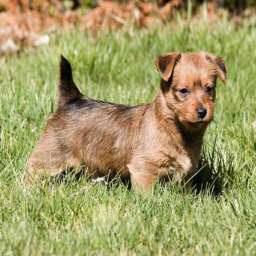

In [15]:
img1

In [16]:
img2, lbl2 = data.train_ds[1]; lbl2

Category n02096294

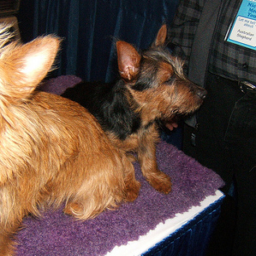

In [17]:
img2

In [0]:
t = 0.4

In [0]:
new_image = t * img1.data + (1-t) * img2.data
new_target = t * lbl1.data + (1-t) * lbl2.data

In [0]:
im = image2np(new_image)

In [0]:
import matplotlib.pyplot as plt

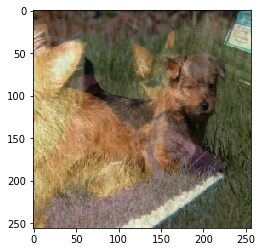

In [36]:
plt.imshow(im)

In [37]:
new_target

5.0

# xResNet

In [0]:
learn = Learner(data, xresnet34(c_out=10), metrics=[accuracy, top_k_accuracy], 
                loss_func = LabelSmoothingCrossEntropy()).mixup()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


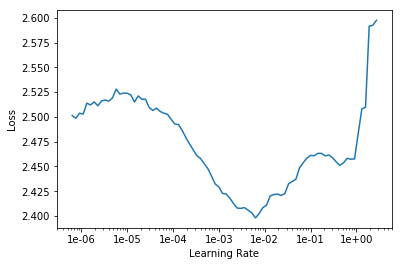

In [54]:
learn.lr_find()
learn.recorder.plot()

In [55]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.224379,2.494749,0.138000,0.640000,01:45
1,2.107443,2.037273,0.314000,0.832000,01:46
2,1.966718,1.805623,0.410000,0.890000,01:46
3,1.828379,1.624335,0.532000,0.920000,01:45
4,1.727088,1.501429,0.556000,0.934000,01:45


# DenseNet